# Grafi delle Province ed Algoritmi

# Costruzione dei Grafi

## Dati per il Grafo P

Dopo aver importato il dataset delle province come DataFrame di Pandas, abbiamo provveduto ad affinarlo per far si che fosse facilmente utilizzabile per poterlo poi rappresentare come grafo.

In [1]:
import json
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open("./data/dpc-covid19-ita-province.json") as f:
    prov = json.load(f)
prov = pd.DataFrame(prov)

In [3]:
prov = (
    prov.drop(
        columns=[
            "data",
            "stato",
            "codice_regione",
            "denominazione_regione",
            "codice_provincia",
            "sigla_provincia",
            "totale_casi",
            "note",
        ],
        axis="columns",
    )
    .groupby("denominazione_provincia")
    .max()
    .drop(
        index=[
            "Fuori Regione / Provincia Autonoma",
            "In fase di definizione",
            "In fase di definizione/aggiornamento",
        ],
        axis="index",
    )
)

Abbiamo quindi ottenuto un DataFrame contenente solo nome della provincia, latitudine e longitudine.

In [4]:
prov

lat       long
denominazione_provincia                      
Agrigento                37.309711  13.584575
Alessandria              44.912974   8.615401
Ancona                   43.616760  13.518875
Aosta                    45.737503   7.320149
Arezzo                   43.466428  11.882288
...                            ...        ...
Vercelli                 45.323981   8.423234
Verona                   45.438390  10.993527
Vibo Valentia            38.676241  16.101574
Vicenza                  45.547497  11.545971
Viterbo                  42.417383  12.104734

[107 rows x 2 columns]

## Dati per il Grafo Q
Per quanto riguarda il grafo Q abbiamo, per prima cosa, dovuto generare 2000 coppie di latitudini e longitudini randomiche, abbiamo inserito tali valori in un DataFrame contenetenti i valori (opportunamente etichettati) e un indice numerico a partire da 0.

In [5]:
np.random.seed(6)
random_couples = np.random.uniform(low=[30, 10], high=[50, 20], size=(2000, 2))
random_couples = pd.DataFrame(random_couples)
random_couples.rename(columns={0: "lat", 1: "long"}, inplace=True)

Abbiamo quindi ottenuto un DataFrame contenente solo un numero intero, latitudine e longitudine.

In [6]:
random_couples

lat       long
0     47.857203  13.319798
1     46.424582  10.416966
2     32.153134  15.950521
3     40.596347  14.188074
4     36.708157  16.225194
...         ...        ...
1995  31.862202  19.333571
1996  37.149266  10.196158
1997  34.867384  18.728994
1998  32.943874  10.151519
1999  36.097508  11.904462

[2000 rows x 2 columns]

## Costruzione dei Grafi
Per costruire i grafi abbiamo implementato una serie di funzioni.

- una per inserire gli archi all'interno del grafo

In [7]:
def insert_edge_from_list(graph, node_list):
    node = node_list.pop(0)
    edge_list = []
    for neigh in node_list:
        edge_list.append((node, neigh))
    graph.add_edges_from(edge_list)
    return graph

- una per filtrare i DataFrame in funzione della distanza (su latitudine e longitudine)

In [8]:
def filter_df(data_frame, province_row, distance):
    return data_frame[
        (data_frame.lat >= province_row.lat - distance)
        & (data_frame.lat <= province_row.lat + distance)
        & (data_frame.long >= province_row.long - distance)
        & (data_frame.long <= province_row.long + distance)
    ]

- e infine una per generare un grafo in cui ogni nodo è collegato ad un altro se rientra, su latitudine e longitudine, entro la distanza pressa in ingresso 

In [9]:
def build_graph_from_df(data_frame, distance):
    graph = nx.Graph()
    graph.add_nodes_from(data_frame.index)
    prov_cpy = data_frame.copy()
    for index, province in prov_cpy.iterrows():
        prov_lat_long = filter_df(prov_cpy, province, distance)
        insert_edge_from_list(graph, prov_lat_long.index.to_list())
        prov_cpy.drop(index=index, inplace=True)
    return graph

I risultati che otteniamo sono i seguenti:

In [10]:
%%timeit
P = build_graph_from_df(prov, 0.8)

149 ms ± 772 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
Q = build_graph_from_df(random_couples, 0.08)

2.77 s ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
P = build_graph_from_df(prov, 0.8)

In [13]:
Q = build_graph_from_df(random_couples, 0.08)

# Aggiunta dei Pesi

Anche per l'aggiunta dei pesi abbiamo implementato una breve funzione

In [14]:
def add_weight(graph, data_frame):
    for edge in graph.edges():
        coord1 = (
            float(data_frame[data_frame.index == edge[0]].lat),
            float(data_frame[data_frame.index == edge[0]].long),
        )
        coord2 = (
            float(data_frame[data_frame.index == edge[1]].lat),
            float(data_frame[data_frame.index == edge[1]].long),
        )
        graph[edge[0]][edge[1]]["weight"] = np.sqrt(
            np.power(coord1[0] - coord2[0], 2) + np.power(coord1[1] - coord2[1], 2)
        )
    return graph

che applichiamo qui di seguito:

In [15]:
%%timeit
add_weight(P, prov)

374 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
add_weight(Q, random_couples)

286 ms ± 5.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Eulerian Path

Per quanto riguarda il percorso euleriano abbiamo deciso di implementare l'algoritmo di Fleury.

Per fare ciò abbiamo implementato una serie di funzioni:

- una per contare il numero di nodi con grado pari e con grado dispari


In [17]:
def count_by_degree(graph):
    even, odd = 0, 0
    for _, degree in graph.degree():
        if degree % 2 == 0:
            even += 1
        else:
            odd += 1
    return even, odd

- una per decidere se un arco è o meno un ponte


In [18]:
def is_bridge(graph, edge):
    return (edge[0], edge[1]) in nx.bridges(graph, root=edge[0]) or (
        edge[1],
        edge[0],
    ) in nx.bridges(graph, root=edge[0])

- una per decidere da dove iniziare il percorso euleriano


In [19]:
def starting_node(graph, odd):
    if odd == 2:
        start = [v for v in graph if graph.degree(v) % 2 != 0][0]
    else:
        start = [v for v in graph if graph.degree(v) % 2 == 0][0]
    return start

- una per sapere se un grafo ha o meno un percorso euleriano


In [20]:
def has_eulerian_walk(graph, odd):
    return (odd == 0 or odd == 2) and nx.is_connected(graph)

- una per decidere di volta in volta che arco seguire


In [21]:
def choose_edge(graph, node, neighbor_list):
    for neighbor in neighbor_list:
        if not is_bridge(graph, (node, neighbor)):
            return (node, neighbor)
    return (node, [neigh for neigh in neighbor_list][0])

- e infine una per trovare un percorso euleriano

In [22]:
def eulerian_walk(graph):
    _, odd = count_by_degree(graph)
    graph_cpy = graph.copy()
    has_eulerian = has_eulerian_walk(graph_cpy, odd)
    if not has_eulerian:
        return None
    else:
        eulerian_walk = []
        node = starting_node(graph_cpy, odd)
        neighbors = graph_cpy[node]
        while len(neighbors) != 0:
            edge = choose_edge(graph_cpy, node, neighbors)
            if edge is None:
                neighbors = []
            else:
                eulerian_walk.append(edge)
                graph_cpy.remove_edge(edge[0], edge[1])
                node = edge[1]
                neighbors = graph_cpy[node]
        return eulerian_walk

Purtroppo nel nostro caso non abbiamo un percorso euleriano.

In [23]:
walk = eulerian_walk(P)
if walk is None:
    print("Non c'è cammino euleriano")
else:
    walk

Non c'è cammino euleriano


In [24]:
walk = eulerian_walk(Q)
if walk is None:
    print("Non c'è cammino euleriano")
else:
    walk

Non c'è cammino euleriano


Possiamo, tuttavia, testare tale metodo con altri grafi, come $K_5$.

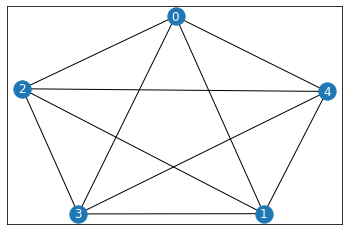

In [25]:
k5 = nx.complete_graph(5)
plt.subplot
nx.draw_networkx(k5, with_labels=True, font_color="#FFFFFF")

In [26]:
for edge in eulerian_walk(k5):
    print(edge, end=" ")

(0, 1) (1, 2) (2, 0) (0, 3) (3, 1) (1, 4) (4, 2) (2, 3) (3, 4) (4, 0) 

# Closeness Centrality

Per il calcolo della closeness centrality abbiamo deciso di utilizzare l'Indice di Lin:

La peculiarità di tale formula è che è pensata per grafi non connessi (mediante il peso che viene fornito ad un nodo in funzione della dimensione della sua componente connessa nei confronti di quella del grafo), tuttavia nel caso di grafi connessi, questa degenera nella formula standard della closeness centrality.

L'implementazione è la seguente:

In [27]:
def closeness_centrality(graph):
    closeness = {}
    n_nodes_of_graph = graph.number_of_nodes()
    for node in graph.nodes():
        distances = list(nx.single_target_shortest_path_length(graph, node))
        n_nodes_of_component = len(distances)
        fareness = 0
        for distance in distances:
            fareness += distance[1]
        if fareness != 0:
            closeness.update(
                {
                    node: (np.power(n_nodes_of_component - 1, 2))
                    / ((n_nodes_of_graph - 1) * fareness)
                }
            )
        else:
            closeness.update({node: 0})
    return closeness

Vediamolo all'opera:

In [28]:
%%timeit
closeness_centrality(P)

22.9 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
closeness_centrality(P)

23 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
closeness_centrality(k5)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

In [31]:
dictP = closeness_centrality(P)
keys = list(dictP.keys())[0:10]
values = list(dictP.values())[0:10]
for i in range(10):
    print(str(keys[i]) + " " + str(values[i]))

Agrigento 0.030874785591766724
Alessandria 0.13030229995868337
Ancona 0.16155126782207804
Aosta 0.10625842318059299
Arezzo 0.18403520715814045
Ascoli Piceno 0.15389150943396226
Asti 0.1250536959323266
Avellino 0.11209679808062557
Bari 0.08302983764809127
Barletta-Andria-Trani 0.09142850240378808


In [32]:
dictQ = closeness_centrality(Q)
keys = list(dictQ.keys())[0:10]
values = list(dictQ.values())[0:10]
for i in range(10):
    print(str(keys[i]) + " " + str(values[i]))

0 0
1 0
2 0
3 0
4 0
5 0
6 0.0005002501250625312
7 0
8 0.0005002501250625312
9 0


# Grazie per l'Attenzione